In [33]:
# Install Library
!pip install pandas-ta

In [41]:
# Impor Library
import yfinance as yf
from datetime import datetime
from dateutil.relativedelta import relativedelta
import pandas as pd
import numpy as np
import pandas_ta as ta

### Data Extraction

In [35]:
#load dataset
start_date = (datetime.now() - relativedelta(years=3)).strftime('%Y-%m-%d')
end_date = datetime.now().strftime('%Y-%m-%d')

df = yf.download("CAT", start=start_date, end=end_date)
if isinstance(df.columns, pd.MultiIndex):
    df.columns = df.columns.get_level_values(0)

df_ori = df.copy()
df.head()

/tmp/ipython-input-1297265356.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download("CAT", start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Date,,,,,
2022-12-22,225.692017,228.789424,221.416467,228.171836,3129900
2022-12-23,227.905777,228.542357,224.703870,225.131422,1959900
2022-12-27,231.012680,232.827417,227.763264,228.684884,3381500
2022-12-28,227.440247,231.658791,226.395106,231.012701,2270000
2022-12-29,228.219345,229.559021,226.385616,229.178978,1652500


### Backtesting Performance

In [36]:
#Define the functions for the strategy
def get_signal_bband(close, length=20):
    buy_date = []
    sell_date = []
    open_pos = False

    if len(close) <= length:
        return buy_date, sell_date

    bb = ta.bbands(close, length=length)
    df_bb = pd.concat([close, bb], axis=1).dropna()

    # AUTO detect BB columns (safe)
    bbl_col = [c for c in df_bb.columns if "BBL" in c][0]
    bbu_col = [c for c in df_bb.columns if "BBU" in c][0]

    for i in range(len(df_bb) - 1):
        if not open_pos:
            if df_bb["Close"].iloc[i] < df_bb[bbl_col].iloc[i]:
                buy_date.append(df_bb.index[i + 1])
                open_pos = True
        else:
            if df_bb["Close"].iloc[i] > df_bb[bbu_col].iloc[i]:
                sell_date.append(df_bb.index[i + 1])
                open_pos = False

    if open_pos and buy_date:
        buy_date.pop()

    return buy_date, sell_date

df = df_ori.copy()
buy_date, sell_date = get_signal_bband(df['Close'])

df.ta.bbands(length=20, append=True)
df.dropna(inplace=True)
df.tail(5)

Price,Close,High,Low,Open,Volume,BBL_20_2.0_2.0,BBM_20_2.0_2.0,BBU_20_2.0_2.0,BBB_20_2.0_2.0,BBP_20_2.0_2.0
Date,,,,,,,,,,
2025-12-15,589.760010,604.150024,587.890015,602.530029,3968600,531.996046,579.405493,626.814940,16.364859,0.609203
2025-12-16,588.929993,598.659973,586.280029,590.700012,2319400,535.479473,581.249493,627.019514,15.748838,0.583903
2025-12-17,561.890015,591.000000,557.460022,587.590027,3753300,538.150940,581.999994,625.849048,15.068404,0.270691
2025-12-18,565.830017,574.659973,561.909973,568.500000,2193000,540.205226,582.635995,625.066765,14.565104,0.301960
2025-12-19,576.219971,581.729980,570.330017,572.690002,5355100,545.166910,584.140494,623.114077,13.343908,0.398386


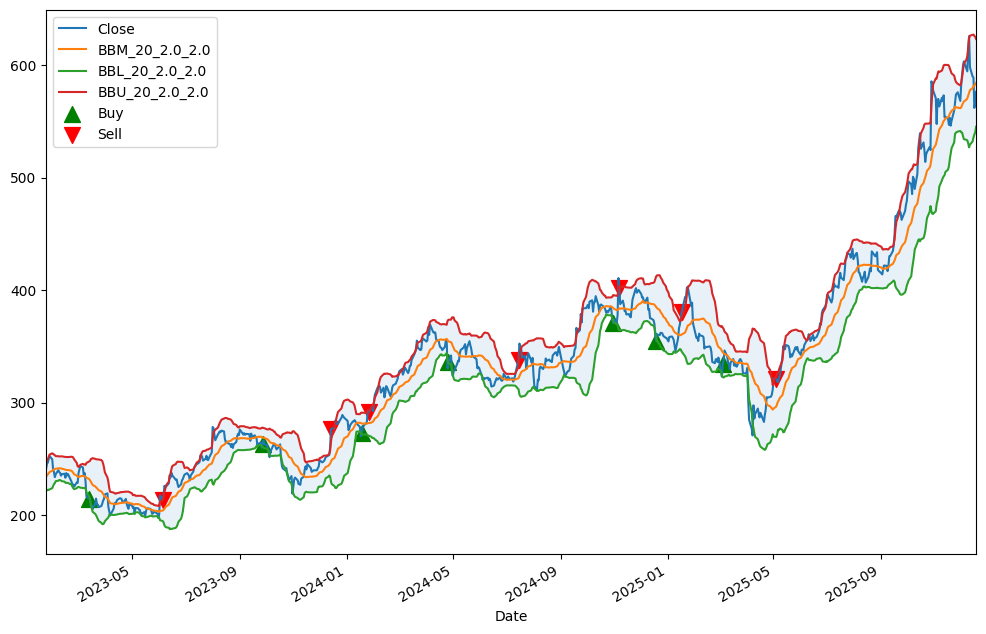

In [38]:
#Visualize Bollinger Bands Strategy
ax = df[['Close', 'BBM_20_2.0_2.0', 'BBL_20_2.0_2.0', 'BBU_20_2.0_2.0']].plot(figsize=(12,8))
ax.fill_between(df.index, df['BBU_20_2.0_2.0'], df['BBL_20_2.0_2.0'], alpha=0.1);
ax.scatter(buy_date, df.loc[buy_date].Close, marker='^', c='g', s=130, label='Buy')
ax.scatter(sell_date, df.loc[sell_date].Close, marker='v', c='r', s=130, label='Sell');
ax.autoscale(tight=True, axis='x');
ax.legend()
ax.grid;

In [39]:
#Calculate the profit
buy_sell = pd.DataFrame({'Buy': df.loc[buy_date,'Open'],
                         'Sell': df.loc[sell_date,'Open']})
buy_sell.tail(5)

,Buy,Sell
Date,,
2024-11-07,NaN,408.747469
2024-12-19,362.958927,NaN
2025-01-17,NaN,378.977064
2025-03-05,325.412468,NaN
2025-05-05,NaN,317.302673


In [42]:
buy_sell['Sell'] = buy_sell['Sell'].shift(-1)
buy_sell.dropna(inplace=True)

profit = (buy_sell.Sell - buy_sell.Buy)/buy_sell.Buy
win = [i for i in profit if i > 0]
pct_win = 100*len(win)/(len(profit)+1e-6)
print(f'Winning percentage: {np.round(pct_win, 2)}%')
print(f'Mean profit: {np.round(np.mean(profit*100), 2)}%')
print(f'Number of transactions: {len(profit)}')

Winning percentage: 83.33%
Mean profit: 11.92%
Number of transactions: 6


In [44]:
# Store the average holding period
hold_day = []
for buy, sell in zip(buy_date, sell_date):
    hold_day.append(sell - buy)
print(f'Mean holding period: {np.mean(hold_day)}')

Mean holding period: 49 days 13:42:51.428571428
